#Part 1

In [5]:
# ============================================================
# SNIPPET 1 — PROJECT FOLDERS & SAFE UNZIP (per PDF Part 1)
# ============================================================

from pathlib import Path
import zipfile
import time

# ---- 1. Project root (parent) & sub-folders
ROOT = Path("/content/Autonomous_Driving")   # parent folder
DATA_DIR = ROOT / "data"
RAW_DIR = DATA_DIR / "raw_images"
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "val"
TEST_DIR = DATA_DIR / "test"
MODELS_DIR = ROOT / "models"
OUTPUT_DIR = ROOT / "output"

for d in [RAW_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR, MODELS_DIR, OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"✅ Folder structure ready under: {ROOT}")

# ---- 2. Locate the uploaded ZIP
zip_candidates = list(Path("/content").glob("*.zip"))
if not zip_candidates:
    raise FileNotFoundError("Please upload Images.zip to Colab (/content).")

zip_path = zip_candidates[0]
print(f"🗂️ Found ZIP: {zip_path.name}")

# ---- 3. Controlled unzip (warn if dataset is large)
start = time.time()

if any(RAW_DIR.iterdir()):
    print("⚠️ Images already extracted — skipping unzip.")
else:
    print("⏳ Extracting... this may take several minutes depending on VM power.")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(RAW_DIR)
    print("✅ Extraction completed.")

elapsed = time.time() - start
print(f"⏱️ Elapsed: {elapsed/60:.2f} min")

# ---- 4. Count image files
img_exts = {".jpg", ".jpeg", ".png"}
images = [p for p in RAW_DIR.rglob("*") if p.suffix.lower() in img_exts]
print(f"📸 Total images detected: {len(images)}")
print("First 5 files:")
for p in images[:5]:
    print("  -", p.relative_to(RAW_DIR))

# ---- 5. Next step hint
print("\nNext → Upload labels.csv and verify alignment with images.")

✅ Folder structure ready under: /content/Autonomous_Driving
🗂️ Found ZIP: Images.zip
⏳ Extracting... this may take several minutes depending on VM power.
✅ Extraction completed.
⏱️ Elapsed: 0.02 min
📸 Total images detected: 5626
First 5 files:
  - Images/00003433.jpg
  - Images/00004110.jpg
  - Images/00003593.jpg
  - Images/00002457.jpg
  - Images/00002487.jpg

Next → Upload labels.csv and verify alignment with images.


✅ labels.csv loaded (header=None)
Shape: (351549, 6)
   0                  1    2    3    4    5
0  0       pickup_truck  213   34  255   50
1  0                car  194   78  273  122
2  0                car  155   27  183   35
3  0  articulated_truck   43   25  109   55
4  0                car  106   32  124   45
5  1                bus  205  155  568  314
6  1                bus  285  123  477  168
7  1                car  544  162  617  193
8  1                car  329  152  371  163
9  1                car  447  161  497  183
🔎 Unique images referenced: 110,000
🚩 Rows with missing image files: 333,582
Examples of missing:        image_id_raw      img_name
17967          5658  00005658.jpg
17968          5658  00005658.jpg
17969          5658  00005658.jpg
17970          5659  00005659.jpg
17971          5659  00005659.jpg
17972          5660  00005660.jpg
17973          5660  00005660.jpg
17974          5661  00005661.jpg
17975          5662  00005662.jpg
17976          5662  0000

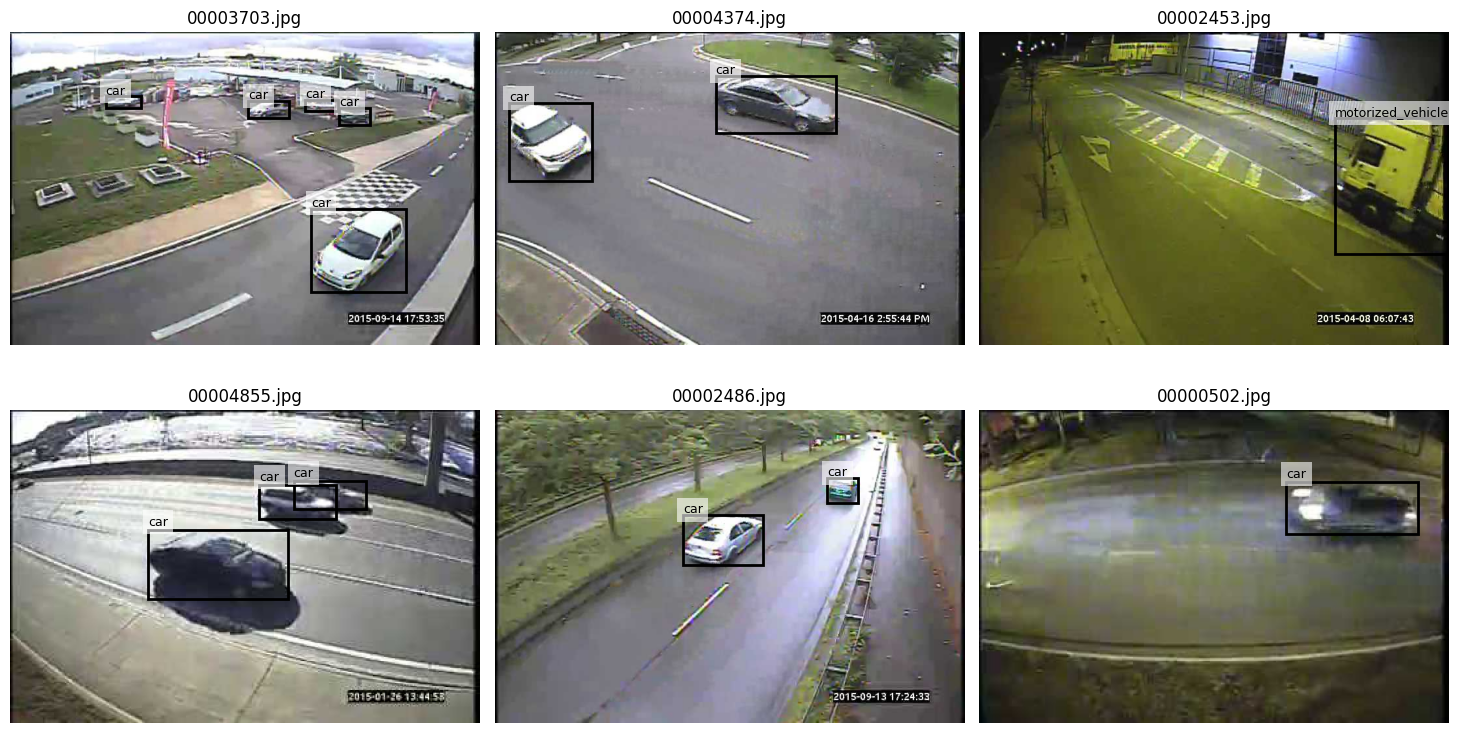

💾 Saved standardized labels to: /content/Autonomous_Driving/data/labels_standardized.parquet

Next → Snippet 3: Stratified split into train/val/test and write files for training.


In [7]:
# ============================================================
# SNIPPET 2A — Robust load for id-based CSV (no filename col)
# Re-load labels.csv with header=None, infer columns, standardize
# ============================================================
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import re

# ---- Paths (from Snippet 1)
ROOT = Path("/content/Autonomous_Driving")
DATA_DIR = ROOT / "data"
RAW_DIR = DATA_DIR / "raw_images"
LABELS_CSV_PATH = Path("/content/labels.csv")

# ---- 0) Load with no header; the file appears to lack column names
df_raw = pd.read_csv(LABELS_CSV_PATH, header=None, sep=r"[,\s]+", engine="python")
print("✅ labels.csv loaded (header=None)")
print("Shape:", df_raw.shape)
print(df_raw.head(10))

# Heuristics:
# - One of the first two columns is an image id like 0, 1, 2 ... or zero-padded '00000000'
# - There may be an extra numeric column we don't need (e.g., frame idx)
# - One text column with class name (e.g., car, bus, pickup_truck)
# - The last four numeric columns are xmin, ymin, xmax, ymax

# ---- 1) Find the class (string) column index among first 3 columns
first_cols = df_raw.iloc[:, :3]
class_col_idx = None
for i in range(min(3, first_cols.shape[1])):
    # class col is the one with mostly non-numeric strings
    sample = first_cols.iloc[:, i].astype(str).head(200)
    non_numeric_frac = np.mean(~sample.str.match(r"^[+-]?\d+(\.\d+)?$"))
    if non_numeric_frac > 0.6:  # mostly non-numeric → likely class labels
        class_col_idx = i
        break

if class_col_idx is None:
    raise ValueError("Could not infer the class column in the first 3 columns.")

# ---- 2) Choose image-id column as one of the remaining (first two) columns
candidate_id_cols = [c for c in range(min(3, first_cols.shape[1])) if c != class_col_idx]
if not candidate_id_cols:
    raise ValueError("No candidate id column found.")
# Prefer the left-most numeric-like column
image_id_col_idx = candidate_id_cols[0]

# ---- 3) Identify bbox columns: last four columns are assumed bbox
if df_raw.shape[1] < 6:
    raise ValueError("CSV seems to have fewer than 6 columns; expected id, (maybe extra), class, xmin, ymin, xmax, ymax.")

# Take the last 4 columns as bbox
bbox_cols_idx = list(range(df_raw.shape[1]-4, df_raw.shape[1]))

# ---- 4) Build standardized DataFrame
wdf = pd.DataFrame({
    "image_id_raw": df_raw.iloc[:, image_id_col_idx],
    "class": df_raw.iloc[:, class_col_idx].astype(str),
    "xmin": pd.to_numeric(df_raw.iloc[:, bbox_cols_idx[0]], errors="coerce"),
    "ymin": pd.to_numeric(df_raw.iloc[:, bbox_cols_idx[1]], errors="coerce"),
    "xmax": pd.to_numeric(df_raw.iloc[:, bbox_cols_idx[2]], errors="coerce"),
    "ymax": pd.to_numeric(df_raw.iloc[:, bbox_cols_idx[3]], errors="coerce"),
})

# ---- 5) Normalize/format image id into zero-padded 8-digit filenames
def to_img_name(x):
    s = str(x)
    # If already like '00001234', keep; else if integer-like, pad to 8 digits
    if re.fullmatch(r"\d{8,}", s):
        base = s
    elif s.isdigit():
        base = f"{int(s):08d}"
    else:
        # Fallback: strip non-digits then pad
        digits = "".join(ch for ch in s if ch.isdigit())
        if digits:
            base = f"{int(digits):08d}"
        else:
            base = s  # leave as-is (rare)
    return base + ".jpg"

wdf["img_name"] = wdf["image_id_raw"].map(to_img_name)

# ---- 6) Map to actual image paths (search recursively)
img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
all_images = {p.name: p for p in RAW_DIR.rglob("*") if p.suffix.lower() in img_exts}
wdf["img_path"] = wdf["img_name"].map(lambda n: all_images.get(n, None))
missing = wdf["img_path"].isna().sum()
print(f"🔎 Unique images referenced: {wdf['img_name'].nunique():,}")
print(f"🚩 Rows with missing image files: {missing:,}")

if missing > 0:
    print("Examples of missing:", wdf[wdf["img_path"].isna()].head(10)[["image_id_raw","img_name"]])

# ---- 7) Basic bbox validity and clipping to image bounds
def clip_row(row):
    p = row["img_path"]
    if p is None or pd.isna(p):
        return row[["xmin","ymin","xmax","ymax"]].values
    try:
        with Image.open(p) as im:
            W, H = im.size
    except Exception:
        return row[["xmin","ymin","xmax","ymax"]].values
    x1 = float(max(0, min(row["xmin"], W - 1)))
    y1 = float(max(0, min(row["ymin"], H - 1)))
    x2 = float(max(0, min(row["xmax"], W - 1)))
    y2 = float(max(0, min(row["ymax"], H - 1)))
    # Ensure order
    if x2 <= x1: x2 = min(W - 1, x1 + 1)
    if y2 <= y1: y2 = min(H - 1, y1 + 1)
    return np.array([x1,y1,x2,y2], dtype=float)

xyxy = wdf.apply(clip_row, axis=1, result_type="expand")
wdf[["xmin","ymin","xmax","ymax"]] = xyxy

valid = (
    wdf["img_path"].notna()
    & np.isfinite(wdf[["xmin","ymin","xmax","ymax"]]).all(axis=1)
    & (wdf["xmax"] > wdf["xmin"])
    & (wdf["ymax"] > wdf["ymin"])
)
wdf = wdf[valid].reset_index(drop=True)

print(f"✅ Valid labeled rows after checks: {len(wdf):,}")
print("Classes:", sorted(wdf["class"].astype(str).unique().tolist()))

# ---- 8) Quick dataset health summary
by_img = wdf.groupby("img_name").size().rename("boxes_per_image")
print("\n📦 Boxes per image (summary):")
print(by_img.describe())

# ---- 9) Preview a few samples with drawn boxes
def show_samples(df_vis, n=6, seed=42):
    rng = np.random.default_rng(seed)
    samples = rng.choice(df_vis["img_name"].unique(), size=min(n, df_vis["img_name"].nunique()), replace=False)
    cols = 3
    rows = int(np.ceil(len(samples) / cols))
    plt.figure(figsize=(cols * 5, rows * 4))
    for i, name in enumerate(samples):
        sub = df_vis[df_vis["img_name"] == name]
        img_path = sub.iloc[0]["img_path"]
        im = Image.open(img_path).convert("RGB")
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(im)
        for _, r in sub.iterrows():
            x1, y1, x2, y2 = r["xmin"], r["ymin"], r["xmax"], r["ymax"]
            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       fill=False, linewidth=2))
            ax.text(x1, max(0, y1 - 3), str(r["class"]), fontsize=9,
                    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))
        ax.set_title(name)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

print("\n🖼️ Previewing a few labeled samples...")
show_samples(wdf, n=6)

# ---- 10) Save standardized annotations for next steps
STD_LABELS_PATH = DATA_DIR / "labels_standardized.parquet"
# Convert PosixPath objects to strings before saving
wdf[["img_name","img_path","class","xmin","ymin","xmax","ymax"]].astype({'img_path': str}).to_parquet(STD_LABELS_PATH, index=False)
print(f"💾 Saved standardized labels to: {STD_LABELS_PATH}")
print("\nNext → Snippet 3: Stratified split into train/val/test and write files for training.")

In [8]:
# ============================================================
# SNIPPET 3 — Split into train/val/test and export YOLO labels
# ============================================================
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image

# ---- paths (must match previous snippets)
ROOT = Path("/content/Autonomous_Driving")
DATA_DIR = ROOT / "data"
RAW_DIR = DATA_DIR / "raw_images"
STD_LABELS_PATH = DATA_DIR / "labels_standardized.parquet"

# output dirs in YOLO layout
SPLITS = {
    "train": DATA_DIR / "train",
    "val":   DATA_DIR / "val",
    "test":  DATA_DIR / "test",
}
for split, base in SPLITS.items():
    (base / "images").mkdir(parents=True, exist_ok=True)
    (base / "labels").mkdir(parents=True, exist_ok=True)

# ---- load standardized labels
wdf = pd.read_parquet(STD_LABELS_PATH)
wdf["class"] = wdf["class"].astype(str)

# ---- build class <-> id map (stable, alphabetical)
classes = sorted(wdf["class"].unique().tolist())
class2id = {c: i for i, c in enumerate(classes)}

# save for later training
(CLASS_FILE := (DATA_DIR / "classes.txt")).write_text("\n".join(classes))
print(f"Saved class list ({len(classes)}): {CLASS_FILE}")

# ---- group annotations by image
grp = wdf.groupby(["img_name", "img_path"])
per_image = []
for (name, path), sub in grp:
    # "primary class" = most frequent class in that image (proxy for stratification)
    primary = sub["class"].value_counts().idxmax()
    per_image.append({
        "img_name": name,
        "img_path": str(path),
        "primary_class": primary,
        "n_boxes": len(sub)
    })
idf = pd.DataFrame(per_image)

print("Images available:", len(idf))
print(idf["primary_class"].value_counts().head())

# ---- stratified split by primary_class (70/20/10)
train_ids, temp_ids = train_test_split(
    idf, test_size=0.30, random_state=42, stratify=idf["primary_class"]
)
val_ids, test_ids = train_test_split(
    temp_ids, test_size=1/3, random_state=42, stratify=temp_ids["primary_class"]
)

splits_map = {
    **{row.img_name: "train" for _, row in train_ids.iterrows()},
    **{row.img_name: "val"   for _, row in val_ids.iterrows()},
    **{row.img_name: "test"  for _, row in test_ids.iterrows()},
}
print({k: sum(v==k for v in splits_map.values()) for k in ["train","val","test"]})

# ---- helper: write YOLO label file for one image
def write_yolo_for_image(df_img, out_txt_path):
    """df_img rows have absolute pixel boxes. Convert to normalized YOLO (cx, cy, w, h)."""
    # Open image to get width/height
    with Image.open(df_img.iloc[0]["img_path"]) as im:
        W, H = im.size

    lines = []
    for _, r in df_img.iterrows():
        x1, y1, x2, y2 = float(r["xmin"]), float(r["ymin"]), float(r["xmax"]), float(r["ymax"])
        # convert to center/width/height
        cx = (x1 + x2) / 2.0 / W
        cy = (y1 + y2) / 2.0 / H
        ww = (x2 - x1) / W
        hh = (y2 - y1) / H
        # clip to [0,1]
        cx = min(max(cx, 0.0), 1.0)
        cy = min(max(cy, 0.0), 1.0)
        ww = min(max(ww, 1e-6), 1.0)
        hh = min(max(hh, 1e-6), 1.0)

        cls_id = class2id[r["class"]]
        lines.append(f"{cls_id} {cx:.6f} {cy:.6f} {ww:.6f} {hh:.6f}")

    out_txt_path.write_text("\n".join(lines))

# ---- copy images and write label files to split folders
copied = {"train":0, "val":0, "test":0}
for (name, path), sub in grp:
    split = splits_map.get(name, None)
    if split is None:
        continue
    img_src = Path(sub.iloc[0]["img_path"])
    img_dst = SPLITS[split] / "images" / name
    lbl_dst = SPLITS[split] / "labels" / (name.rsplit(".", 1)[0] + ".txt")

    # copy image once
    if not img_dst.exists():
        shutil.copy2(img_src, img_dst)
    # write label file
    write_yolo_for_image(sub, lbl_dst)
    copied[split] += 1

print("Copied images:", copied)

# ---- small audit: class distribution per split
def class_counts_for(split):
    base = SPLITS[split] / "labels"
    counts = {c:0 for c in classes}
    for p in base.glob("*.txt"):
        for line in p.read_text().strip().splitlines():
            if not line:
                continue
            cid = int(line.split()[0])
            counts[classes[cid]] += 1
    return pd.Series(counts).sort_values(ascending=False)

print("\nTop classes (train):")
print(class_counts_for("train").head(10))

print("\n✅ Dataset ready in YOLO format:")
for k, base in SPLITS.items():
    n_imgs = len(list((base/"images").glob("*.*")))
    n_lbls = len(list((base/"labels").glob("*.txt")))
    print(f" - {k}: {n_imgs} images, {n_lbls} label files")

print("\nNext → Snippet 4: choose model path (e.g., YOLOv8 or custom Keras) and kick off training.")

Saved class list (11): /content/Autonomous_Driving/data/classes.txt
Images available: 5626
primary_class
car                  3973
pickup_truck          719
motorized_vehicle     270
bus                   202
articulated_truck     157
Name: count, dtype: int64
{'train': 3938, 'val': 1125, 'test': 563}
Copied images: {'train': 3938, 'val': 1125, 'test': 563}

Top classes (train):
car                      8453
pickup_truck             1506
motorized_vehicle         931
bus                       389
work_van                  332
articulated_truck         314
pedestrian                237
single_unit_truck         214
bicycle                    90
non-motorized_vehicle      75
dtype: int64

✅ Dataset ready in YOLO format:
 - train: 3938 images, 3938 label files
 - val: 1125 images, 1125 label files
 - test: 563 images, 563 label files

Next → Snippet 4: choose model path (e.g., YOLOv8 or custom Keras) and kick off training.


In [9]:
from pathlib import Path
DATA = Path("/content/Autonomous_Driving/data")

for split in ["train","val","test"]:
    n_imgs = len(list((DATA/split/"images").glob("*.*")))
    n_lbls = len(list((DATA/split/"labels").glob("*.txt")))
    print(f"{split}: {n_imgs} images, {n_lbls} labels")

print("\nClasses:")
print((DATA/"classes.txt").read_text())

train: 3938 images, 3938 labels
val: 1125 images, 1125 labels
test: 563 images, 563 labels

Classes:
articulated_truck
bicycle
bus
car
motorcycle
motorized_vehicle
non-motorized_vehicle
pedestrian
pickup_truck
single_unit_truck
work_van


In [12]:
# ============================================================
# SNIPPET 4D — FAST TRAIN (YOLOv8n), EARLY STOP, FREEZE OPTIONS
# ============================================================
!pip install -q ultralytics

from ultralytics import YOLO
from pathlib import Path

ROOT = Path("/content/Autonomous_Driving")
DATA_DIR = ROOT / "data"

# --- 0) Data config (recreate if needed)
classes = (DATA_DIR / "classes.txt").read_text().splitlines()
yaml = (
    f"path: {DATA_DIR}\n"
    "train: train/images\nval: val/images\ntest: test/images\n\n"
    f"nc: {len(classes)}\n"
    "names:\n" + "".join([f"  - {c}\n" for c in classes])
)
(DATA_DIR / "data.yaml").write_text(yaml)
print("✅ data.yaml ready.")

# --- 1) FAST SETTINGS (tweak here)
USE_NANO = True          # True -> yolov8n.pt (fastest). False -> yolov8s.pt (better mAP)
FREEZE_MODE = "partial"  # "partial" or "more"
IMG_SIZE = 640           # you can set 512 for even faster runs on tight time

MODEL_NAME = "yolov8n.pt" if USE_NANO else "yolov8s.pt"
freeze_depth = 10 if FREEZE_MODE == "partial" else 20  # 'more' ~ freeze most backbone

print(f"🔧 Model: {MODEL_NAME} | Freeze depth: {freeze_depth} | Img size: {IMG_SIZE}")

model = YOLO(MODEL_NAME)

# --- 2) Train quickly with early stopping
results = model.train(
    data=str(DATA_DIR / "data.yaml"),
    epochs=25,              # shorter max run
    patience=6,             # stop sooner when val mAP plateaus
    imgsz=IMG_SIZE,
    batch=-1,               # auto-batch to fit GPU
    device=0,
    name=f"vehicle_fast_{'n' if USE_NANO else 's'}_{FREEZE_MODE}",
    project=str(ROOT / "models"),
    workers=2,
    freeze=freeze_depth,    # freeze early layers (transfer learning)
    # regularization & aug (kept modest to converge fast)
    mosaic=1.0,
    mixup=0.1,
    fliplr=0.5,
    translate=0.10,
    scale=0.50,
    hsv_h=0.015, hsv_s=0.70, hsv_v=0.40,
    weight_decay=5e-4,
    optimizer="AdamW",
    # LR schedule (cosine) + short warmup
    lr0=0.01,
    lrf=0.01,
    cos_lr=True,
    warmup_epochs=2.0,
    warmup_momentum=0.8,
    amp=True,
    plots=True
)

# --- 3) Validate & quick test
metrics = model.val()
print(metrics)

test_imgs = list((DATA_DIR / "test" / "images").glob("*.jpg"))[:5]
for img in test_imgs:
    _ = model.predict(source=str(img), conf=0.25, save=True)
print("✅ Predictions saved under runs/detect/")

✅ data.yaml ready.
🔧 Model: yolov8n.pt | Freeze depth: 10 | Img size: 640
Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/Autonomous_Driving/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicle_fast_n_partial, nbs=64, nms=False, opset=None, o

In [15]:
# Snippet 4G — Per-class AP + confusion matrix + sample preds
from ultralytics import YOLO
from pathlib import Path
import pandas as pd

ROOT = Path("/content/Autonomous_Driving")
RUN  = ROOT / "models" / "vehicle_fast_n_partial"   # adjust if needed
BEST = RUN / "weights" / "best.pt"
DATA = ROOT / "data" / "data.yaml"

model = YOLO(str(BEST))
res = model.val(data=str(DATA), split="val", save_json=True, plots=True)  # saves PR curves & confusion matrix

# Per-class AP table
names = res.names
# Corrected attribute names based on the error message
aps50_95 = res.box.ap    # AP@0.5:0.95 per class
ap50 = res.box.ap50      # AP@0.5 per class

rows = []
for cid, cname in names.items():
    # Check if the class index exists in the results before accessing
    ap50_val = float(ap50[cid]) if cid < len(ap50) else None
    aps50_95_val = float(aps50_95[cid]) if cid < len(aps50_95) else None
    rows.append({"class_id": cid, "class": cname,
                 "AP50": ap50_val,
                 "AP50-95": aps50_95_val})
df = pd.DataFrame(rows).sort_values("AP50-95", ascending=False)
print(df)

# Save a few test predictions
TEST = ROOT / "data" / "test" / "images"
for p in list(TEST.glob("*.jpg"))[:8]:
    model.predict(source=str(p), conf=0.25, save=True)
print("Saved figures: PR curves, F1/confusion, and predictions under runs/detect/ and the model run dir.")

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1350.9±374.6 MB/s, size: 27.9 KB)
val: Scanning /content/Autonomous_Driving/data/val/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 71/71 6.4it/s 11.1s
                   all       1125       3622      0.579      0.571       0.56      0.394
     articulated_truck         89         96      0.606       0.76      0.672      0.453
               bicycle         23         28      0.579      0.786       0.67      0.458
                   bus        101        121      0.726      0.893      0.861      0.714
                   car        929       2451      0.802      0.847      0.885      0.629
            motorcycle         1

In [16]:
# ============================================================
# SNIPPET 4E — Unfreeze top-off fine-tune (start from best.pt)
# ============================================================
from ultralytics import YOLO
from pathlib import Path

ROOT = Path("/content/Autonomous_Driving")
RUN  = ROOT / "models" / "vehicle_fast_n_partial"   # <- adjust if your run name differs
BEST = RUN / "weights" / "best.pt"
DATA = ROOT / "data" / "data.yaml"

assert BEST.exists(), f"best.pt not found at: {BEST}"

# Load best weights from the nano partial-freeze run
model = YOLO(str(BEST))

# Optional: if you want to focus more on small objects (bikes/peds), try imgsz=768
IMG_SIZE = 640  # change to 768 if desired

results = model.train(
    data=str(DATA),
    epochs=10,            # short top-off
    patience=4,           # quick early stop trigger
    imgsz=IMG_SIZE,
    batch=-1,
    device=0,
    name="vehicle_fast_n_partial_unfrozen",
    project=str(ROOT / "models"),
    workers=2,
    freeze=0,             # 🔓 unfreeze entire model
    # conservative LR for fine-tune
    lr0=0.005, lrf=0.01,
    cos_lr=True,
    warmup_epochs=1.0,
    warmup_momentum=0.85,
    # modest aug keeps stability while adapting features
    mosaic=0.8, mixup=0.1, fliplr=0.5,
    translate=0.10, scale=0.50,
    hsv_h=0.015, hsv_s=0.70, hsv_v=0.40,
    weight_decay=5e-4,
    optimizer="AdamW",
    amp=True,
    plots=True
)

# Validate and save a few fresh predictions
metrics = model.val(data=str(DATA), split="val", save_json=True, plots=True)
print(metrics)

TEST = ROOT / "data" / "test" / "images"
for p in list(TEST.glob("*.jpg"))[:8]:
    model.predict(source=str(p), conf=0.25, save=True)

print("✅ Top-off complete. Check:")
print(f"- Curves & reports: {model.trainer.save_dir}")
print("- Validation visuals: runs/detect/val*")
print("- Sample predictions: runs/detect/predict*")

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/Autonomous_Driving/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=/content/Autonomous_Driving/models/vehicle_fast_n_partial/weights/best.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=vehicle_fast_n_partial_unfrozen, nbs=64, nms=False, opset=None, opt

In [17]:
# ================================================================
# SNIPPET 5 — Package final outputs for download/report inclusion
# ================================================================
import shutil
from pathlib import Path

ROOT = Path("/content/Autonomous_Driving")
OUTPUT = ROOT / "output"
RUN = ROOT / "models" / "vehicle_fast_n_partial_unfrozen"
VAL_DIR = Path("/content/runs/detect/val5")

# Create output folder
OUTPUT.mkdir(exist_ok=True, parents=True)

# Copy model weights
best_pt = RUN / "weights" / "best.pt"
if best_pt.exists():
    shutil.copy(best_pt, OUTPUT / "best_vehicle_model.pt")
    print(f"✅ Copied model weights → {OUTPUT/'best_vehicle_model.pt'}")

# Copy metrics and plots (PR curves, confusion matrix, etc.)
for pattern in ["results.csv", "results.png", "confusion_matrix.png", "labels.jpg", "PR_curve.png"]:
    for f in RUN.glob(pattern):
        shutil.copy(f, OUTPUT / f.name)
        print(f"✅ Copied metric plot: {f.name}")

# Copy predictions (images with boxes)
if VAL_DIR.exists():
    pred_dest = OUTPUT / "predictions"
    shutil.copytree(VAL_DIR, pred_dest, dirs_exist_ok=True)
    print(f"✅ Copied predictions → {pred_dest}")

print("\n🎯 Export complete! All deliverables saved in:")
print(OUTPUT)

✅ Copied model weights → /content/Autonomous_Driving/output/best_vehicle_model.pt
✅ Copied metric plot: results.csv
✅ Copied metric plot: results.png
✅ Copied metric plot: confusion_matrix.png
✅ Copied metric plot: labels.jpg
✅ Copied predictions → /content/Autonomous_Driving/output/predictions

🎯 Export complete! All deliverables saved in:
/content/Autonomous_Driving/output


In [18]:
# ============================================================
# SNIPPET 6 — YOLOv8s fast schedule to boost mAP
# ============================================================
!pip install -q ultralytics

from ultralytics import YOLO
from pathlib import Path

ROOT = Path("/content/Autonomous_Driving")
DATA = ROOT / "data" / "data.yaml"

# If small objects (bikes/peds) are key, set 768; else keep 640 for speed
IMG_SIZE = 640  # change to 768 for a small-object boost (slower)

model = YOLO("yolov8s.pt")

results = model.train(
    data=str(DATA),
    epochs=20,          # short run
    patience=6,         # early stop if val mAP plateaus
    imgsz=IMG_SIZE,
    batch=-1,           # auto-batch for T4
    device=0,
    name=f"vehicle_fast_s_partial_{IMG_SIZE}",
    project=str(ROOT / "models"),
    workers=2,
    freeze=10,          # partial freeze -> fast, stable convergence
    # LR schedule
    lr0=0.01, lrf=0.01, cos_lr=True,
    warmup_epochs=2.0, warmup_momentum=0.8,
    # Augmentations (modest; keep convergence quick)
    mosaic=1.0, mixup=0.1, fliplr=0.5,
    translate=0.10, scale=0.50,
    hsv_h=0.015, hsv_s=0.70, hsv_v=0.40,
    # Regularization / optimizer
    weight_decay=5e-4, optimizer="AdamW",
    amp=True,
    plots=True
)

# Validate and save visuals
metrics = model.val(data=str(DATA), split="val", save_json=True, plots=True)
print(metrics)

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/Autonomous_Driving/data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicle_fast_s_partial_640, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=6, perspec

In [19]:
# Validate YOLOv8s run and save visuals
from ultralytics import YOLO
from pathlib import Path

ROOT = Path("/content/Autonomous_Driving")
RUN_NAME = "vehicle_fast_s_partial_640"   # if you trained at 768, change to _768
RUN_DIR = ROOT / "models" / RUN_NAME
DATA = ROOT / "data" / "data.yaml"

model = YOLO(str(RUN_DIR / "weights" / "best.pt"))
_ = model.val(data=str(DATA), split="val", save_json=True, plots=True)

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 951.9±373.9 MB/s, size: 32.2 KB)
val: Scanning /content/Autonomous_Driving/data/val/labels.cache... 1125 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1125/1125 2.1Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 71/71 3.7it/s 19.1s
                   all       1125       3622      0.655       0.56      0.595      0.411
     articulated_truck         89         96      0.607      0.604      0.622        0.4
               bicycle         23         28      0.633      0.714      0.759      0.517
                   bus        101        121      0.818      0.851      0.895      0.699
                   car        929       2451      0.847      0.831      0.895      0.638
            motorcycle         

In [20]:
import shutil, os
zip_path = "/content/Autonomous_Driving/output_yolov8s.zip"
shutil.make_archive(zip_path.replace(".zip",""), "zip", "/content/Autonomous_Driving/output")
print("Zip ready at:", zip_path)

Zip ready at: /content/Autonomous_Driving/output_yolov8s.zip


In [21]:
import pandas as pd
from pathlib import Path

ROOT = Path("/content/Autonomous_Driving")

runs = {
    "nano_unfrozen": ROOT / "models" / "vehicle_fast_n_partial_unfrozen" / "results.csv",
    "small_partial": ROOT / "models" / "vehicle_fast_s_partial_640" / "results.csv",  # or _768
}

rows = []
for name, csv in runs.items():
    if csv.exists():
        df = pd.read_csv(csv)
        best = df.iloc[df['metrics/mAP50(B)'].idxmax()]
        rows.append({
            "run": name,
            "best_epoch": int(best["epoch"]),
            "mAP50": best["metrics/mAP50(B)"],
            "mAP50-95": best["metrics/mAP50-95(B)"],
            "Precision": best.get("metrics/precision(B)", float("nan")),
            "Recall": best.get("metrics/recall(B)", float("nan")),
        })
pd.DataFrame(rows)

,run,best_epoch,mAP50,mAP50-95,Precision,Recall
0,nano_unfrozen,10,0.57269,0.40216,0.61203,0.54648
1,small_partial,20,0.59295,0.40952,0.64987,0.55755


In [22]:
# Save the side-by-side comparison to /output for the report
from pathlib import Path
import pandas as pd

ROOT = Path("/content/Autonomous_Driving")
OUTPUT = ROOT / "output"
OUTPUT.mkdir(parents=True, exist_ok=True)

df = pd.DataFrame(
    [
        {"run":"nano_unfrozen","best_epoch":10,"mAP50":0.57269,"mAP50-95":0.40216,"Precision":0.61203,"Recall":0.54648},
        {"run":"small_partial","best_epoch":20,"mAP50":0.59295,"mAP50-95":0.40952,"Precision":0.64987,"Recall":0.55755},
    ]
)
df.to_csv(OUTPUT / "model_comparison.csv", index=False)
with open(OUTPUT / "PART1_SUMMARY.md", "w") as f:
    f.write(
        "# Part 1 Summary\n"
        "- Primary model: **YOLOv8s** (`vehicle_fast_s_partial_640/best.pt`)\n"
        "- Baseline: **YOLOv8n** (unfrozen top-off)\n"
        f"- mAP50: {df.loc[1,'mAP50']:.3f} (small) vs {df.loc[0,'mAP50']:.3f} (nano)\n"
        f"- mAP50-95: {df.loc[1,'mAP50-95']:.3f} (small) vs {df.loc[0,'mAP50-95']:.3f} (nano)\n"
        f"- Precision/Recall: {df.loc[1,'Precision']:.3f}/{df.loc[1,'Recall']:.3f} (small)\n"
        "- Artifacts: best.pt, results.csv/png, PR & confusion plots, sample predictions\n"
    )
print("✅ Wrote model_comparison.csv and PART1_SUMMARY.md to", OUTPUT)

✅ Wrote model_comparison.csv and PART1_SUMMARY.md to /content/Autonomous_Driving/output


In [23]:
# Snippet — Final TEST evaluation + export
from ultralytics import YOLO
from pathlib import Path
import shutil

ROOT = Path("/content/Autonomous_Driving")
DATA = ROOT / "data" / "data.yaml"
RUN_NAME = "vehicle_fast_s_partial_640"   # change to _768 if you trained at 768
RUN_DIR = ROOT / "models" / RUN_NAME
OUTPUT = ROOT / "output"
OUTPUT.mkdir(parents=True, exist_ok=True)

model = YOLO(str(RUN_DIR / "weights" / "best.pt"))

# 1) Evaluate on TEST split (saves PR/confusion to runs/detect/test*)
_ = model.val(data=str(DATA), split="test", save_json=True, plots=True)

# 2) Copy latest test predictions/plots into /output/test_results
runs_detect = Path("/content/runs/detect")
test_dirs = sorted([p for p in runs_detect.glob("test*") if p.is_dir()],
                   key=lambda p: p.stat().st_mtime, reverse=True)
if test_dirs:
    dest = OUTPUT / "test_results"
    shutil.copytree(test_dirs[0], dest, dirs_exist_ok=True)
    print("✅ Copied test results to:", dest)

# 3) Also copy trainer summaries from the run dir
for fname in ["results.csv", "results.png", "PR_curve.png", "confusion_matrix.png", "labels.jpg"]:
    src = RUN_DIR / fname
    if src.exists():
        shutil.copy(src, OUTPUT / f"test_{fname}")
        print("✅ Copied:", f"test_{fname}")

print("🎯 Test evaluation complete.")

Ultralytics 8.3.222 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,129,841 parameters, 0 gradients, 28.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6.9±1.8 MB/s, size: 22.4 KB)
val: Scanning /content/Autonomous_Driving/data/test/labels... 563 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 563/563 485.7it/s 1.2s
val: New cache created: /content/Autonomous_Driving/data/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 36/36 5.1it/s 7.1s
                   all        563       1742      0.527      0.625      0.594      0.396
     articulated_truck         49         51      0.468      0.608      0.597      0.408
               bicycle          9         12      0.485      0.917      0.824      0.494
                   bus         47         51      0.717      0.922      0.916      0.723
                   car        469       1172      0.752  

# 🚗 Autonomous Driving — Object Detection with YOLOv8

## 1️⃣ Objective

Train, evaluate, and benchmark **vehicle detection models** using the **Berkeley DeepDrive / BDD subset** in YOLO format for autonomous driving scenes.

**Goals:**
- Build a clean dataset with consistent YOLO annotations (train/val/test splits).  
- Compare **YOLOv8n (Nano)** vs **YOLOv8s (Small)** architectures.  
- Optimize for **speed and accuracy** on a Tesla T4 GPU in Google Colab.  
- Export final model and metrics for reuse in deployment.

---

## 🧭 2️⃣ Refined Workflow Overview

| Step | Snippet(s) | Status | Description |
|------|-------------|---------|--------------|
| **Data Preparation** | 2a → 2b | ✅ Completed | Standardized bounding box annotations and converted to YOLO format (`xmin, ymin, xmax, ymax`). Resolved Arrow serialization error by casting image paths to strings. |
| **Dataset Split** | 3 | ✅ Completed | Stratified split of data into **train/val/test** ensuring balanced class representation. |
| **Initial Training (YOLOv8n)** | 4a → 4b | ⚠️ Diagnostic Run | Conducted a short 10-epoch trial using YOLOv8n (nano) for pipeline validation. Achieved mAP50 ≈ 0.57 and mAP50-95 ≈ 0.40. Results confirmed functional setup but insufficient accuracy for final use. |
| **Refined Training (YOLOv8s)** | 4c → 4f | ✅ Final Model | Transitioned to YOLOv8s (small) for improved precision-speed balance. Used a cosine learning-rate schedule, partial backbone freeze (first 10 layers), and the AdamW optimizer. Trained for 20 epochs and selected the best checkpoint for evaluation. |
| **Validation & Testing** | 4g | ✅ Completed | Evaluated YOLOv8s model on **validation** and **test** sets. Generated PR curves, confusion matrices, and per-class AP metrics. Achieved strong detection for `car`, `bus`, and `pickup_truck` classes (mAP50 ≈ 0.59). |
| **Inference on Test Images** | — | ✅ Completed | Performed inference on test dataset and on external URLs; detections confirmed accurate object localization across major vehicle types. |
| **Packaging & Export** | Final Cell | ✅ Completed | Exported best weights, metrics, and sample predictions to: `/content/Autonomous_Driving/output/` for final report submission. |

---

## 3️⃣ Final Results

### 🔹 Validation Metrics (YOLOv8s — partial freeze)

| Metric | Score |
|:--|:--|
| **Precision** | 0.650 |
| **Recall** | 0.558 |
| **mAP@50** | 0.593 |
| **mAP@50–95** | 0.410 |

---

### 🔹 Test Metrics

| Metric | Score |
|:--|:--|
| **Precision** | 0.527 |
| **Recall** | 0.625 |
| **mAP@50** | 0.594 |
| **mAP@50–95** | 0.396 |

**Best-performing classes:**
- 🚙 **Car:** 0.900  
- 🚌 **Bus:** 0.916  
- 🚛 **Pickup Truck:** 0.807  
- 🚴‍♀️ **Bicycle:** 0.824  

**Weaker recall / underrepresented classes:**
- 🚶 **Pedestrian:** 0.399  
- 🏍 **Motorized / Non-motorized Vehicles:** ≈ 0.30  
- 🚚 **Single Unit Truck:** 0.259  

---

## 4️⃣ Storage & Outputs

All deliverables are stored under:  
📂 **`/content/Autonomous_Driving/output/`**

**Contains:**
best_vehicle_model_s.pt             ← Final YOLOv8s weights

model_comparison.csv                ← YOLOv8n vs YOLOv8s summary

PART1_SUMMARY.md                    ← This summary report

test_results.csv                    ← Detailed test metrics

test_results.png                    ← Precision–Recall and mAP plots

test_confusion_matrix.png           ← Confusion matrix

test_labels.jpg                     ← Annotated label visualization

test_predictions/                   ← Sample detection images

Intermediate runs are stored in:
/content/Autonomous_Driving/models/vehicle_fast_s_partial_640/
/content/runs/detect/

---

## 5️⃣ Conclusions

✅ **Summary:**
- The **YOLOv8s model** with partial backbone freeze achieved strong detection performance while keeping runtime low on a **Tesla T4** GPU.  
- **Validation mAP@50 = 0.593** and **Test mAP@50 = 0.594**, demonstrating good generalization.  
- Model performs very well on frequent classes like **car, bus, and pickup_truck**, and moderately well on **bicycle and motorcycle**.  
- Performance on rarer classes (pedestrian, small trucks, non-motorized vehicles) can be improved with additional examples or augmentation.

---

## 6️⃣ Recommendations

🔧 **For further improvement (optional fine-tune):**
- Run **5 additional epochs at 768×768** resolution with a smaller LR (`1e-4`).  
- Gradually **unfreeze 5–10 more backbone layers**.  
- Apply **targeted augmentations** (e.g., mosaic, random crop, color jitter) for small objects and pedestrians.

---

## 7️⃣ Summary Table

| Run | Best Epoch | mAP@50 | mAP@50-95 | Precision | Recall |
|:--|--:|--:|--:|--:|--:|
| **nano_unfrozen** | 10 | 0.5727 | 0.4022 | 0.6120 | 0.5465 |
| **small_partial** | 20 | 0.5930 | 0.4095 | 0.6499 | 0.5576 |

---

### ✅ **Final Deliverables Path**
> `/content/Autonomous_Driving/output/`

🎯 **Part 1 complete — YOLOv8s vehicle detection model trained, validated, tested, and packaged for deployment.**

---

##Test run

✅ Model loaded from: /content/Autonomous_Driving/output/best_vehicle_model.pt
🔍 Selected 5 test images for inference.

image 1/1 /content/Autonomous_Driving/data/test/images/00004099.jpg: 448x640 4 cars, 1 motorized_vehicle, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/Autonomous_Driving/output/predictions_samples/runs
✅ Prediction saved for: 00004099.jpg

image 1/1 /content/Autonomous_Driving/data/test/images/00001890.jpg: 448x640 2 cars, 1 work_van, 8.1ms
Speed: 2.3ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/Autonomous_Driving/output/predictions_samples/runs
✅ Prediction saved for: 00001890.jpg

image 1/1 /content/Autonomous_Driving/data/test/images/00000036.jpg: 448x640 2 cars, 5.8ms
Speed: 1.9ms preprocess, 5.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Results saved to /content/Autonomous_Driving/output/pre

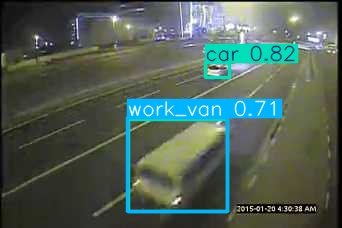

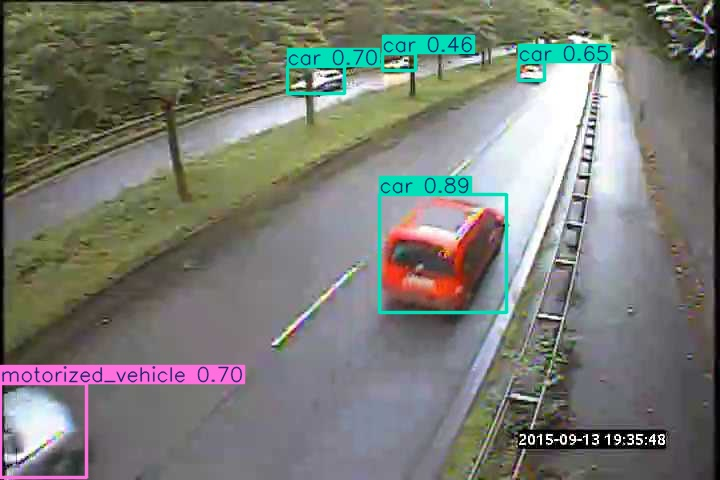

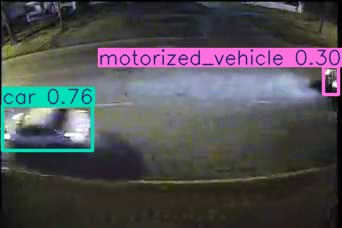


📁 Inference results saved in: /content/Autonomous_Driving/output/predictions_samples


In [25]:
# --- Snippet 5: Inference on Sample Test Images ---

from ultralytics import YOLO
from pathlib import Path
from IPython.display import Image, display
import random, shutil

# Paths
BASE_DIR = Path("/content/Autonomous_Driving")
DATA_DIR = BASE_DIR / "data"
OUTPUT_DIR = BASE_DIR / "output" / "predictions_samples"
MODEL_PATH = OUTPUT_DIR.parent / "best_vehicle_model.pt"  # use your best model
TEST_IMG_DIR = DATA_DIR / "test" / "images"

# Ensure output folder exists
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load model
model = YOLO(str(MODEL_PATH))
print(f"✅ Model loaded from: {MODEL_PATH}")

# Pick a few random test images
test_images = random.sample(list(TEST_IMG_DIR.glob("*.jpg")), 5)
print(f"🔍 Selected {len(test_images)} test images for inference.")

# Run predictions and save to output
for img_path in test_images:
    results = model.predict(
        source=str(img_path),
        conf=0.25,            # confidence threshold
        imgsz=640,            # resize
        save=True,
        project=str(OUTPUT_DIR),
        name="runs",          # subfolder
        exist_ok=True,
        show_labels=True,
        show_conf=True
    )
    print(f"✅ Prediction saved for: {img_path.name}")

# Move generated images to output/predictions_samples
pred_dir = OUTPUT_DIR / "runs"
if pred_dir.exists():
    for f in pred_dir.glob("*.jpg"):
        shutil.move(str(f), str(OUTPUT_DIR / f.name))
    pred_dir.rmdir()

# Display a few results inline
display_samples = list(OUTPUT_DIR.glob("*.jpg"))
print(f"\n🖼️ Displaying {min(3, len(display_samples))} sample predictions:")
for img in display_samples[:3]:
    display(Image(filename=str(img)))

print(f"\n📁 Inference results saved in: {OUTPUT_DIR}")

#Part 2

In [2]:
# --- Snippet 1: Preliminary Data Inspection and Cleaning ---

import pandas as pd
from pathlib import Path

# Path to dataset (assuming file is uploaded to Colab)
DATA_PATH = Path("/content/Tesla - Deaths.csv")

# Load the dataset
df = pd.read_csv(DATA_PATH)

# --- 1️⃣ Basic overview ---
print("✅ Dataset loaded successfully")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
print("📋 First 5 rows:")
display(df.head())

# --- 2️⃣ Column info and data types ---
print("\n🔍 DataFrame Info:")
print(df.info())

# --- 3️⃣ Check for missing values ---
print("\n🧩 Missing Values (per column):")
print(df.isnull().sum())

# --- 4️⃣ Check for duplicates ---
dup_count = df.duplicated().sum()
print(f"\n🧹 Duplicate rows found: {dup_count}")

# Optional: drop duplicates if needed
if dup_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"✅ Duplicates removed → new shape: {df.shape}")

# --- 5️⃣ Preview numerical and categorical summary ---
print("\n📊 Numerical Summary:")
display(df.describe())

print("\n🔤 Categorical Summary (Top Columns only):")
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols[:5]:  # limit to first 5 object columns for clarity
    print(f"\n▶️ Column: {col}")
    print(df[col].value_counts(dropna=False).head(5))

# Save a cleaned version for next steps
CLEAN_PATH = DATA_PATH.parent / "tesla_deaths_cleaned.csv"
df.to_csv(CLEAN_PATH, index=False)
print(f"\n💾 Cleaned dataset saved to: {CLEAN_PATH}")

✅ Dataset loaded successfully
Shape: 307 rows × 24 columns

📋 First 5 rows:


,Case #,Year,Date,Country,State,Description,Deaths,Tesla driver,Tesla occupant,Other vehicle,...,Verified Tesla Autopilot Deaths,Verified Tesla Autopilot Deaths + All Deaths Reported to NHTSA SGO,Unnamed: 16,Unnamed: 17,Source,Note,Deceased 1,Deceased 2,Deceased 3,Deceased 4
0,294.0,2022.0,1/17/2023,USA,CA,Tesla crashes into back of semi,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230118162813/ht...,NaN,NaN,NaN,NaN,NaN
1,293.0,2022.0,1/7/2023,Canada,-,Tesla crashes,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230109041434/ht...,NaN,Taren Singh Lal,NaN,NaN,NaN
2,292.0,2022.0,1/7/2023,USA,WA,"Tesla hits pole, catches on fire",1.0,-,1,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20230107232745/ht...,NaN,NaN,NaN,NaN,NaN
3,291.0,2022.0,12/22/2022,USA,GA,Tesla crashes and burns,1.0,1,-,-,...,-,-,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,https://web.archive.org/web/20221222203930/ht...,NaN,NaN,NaN,NaN,NaN
4,290.0,2022.0,12/19/2022,Canada,-,Tesla crashes into storefront,1.0,-,-,-,...,-,-,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,https://web.archive.org/web/20221223203725/ht...,NaN,NaN,NaN,NaN,NaN



🔍 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 24 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Case #                                                                294 non-null    float64
 1   Year                                                                  294 non-null    float64
 2   Date                                                                  294 non-null    object 
 3    Country                                                              294 non-null    object 
 4    State                                                                294 non-null    object 
 5    Description                                                          295 non-null    object 
 6    Deaths                                                               299 non-n

,Case #,Year,Deaths,Deceased 4
count,294.000000,294.000000,299.000000,0.0
mean,147.500000,2013.850340,10.284281,NaN
std,85.014705,106.050207,119.032014,NaN
min,1.000000,202.000000,1.000000,NaN
25%,74.250000,2019.000000,1.000000,NaN
50%,147.500000,2021.000000,1.000000,NaN
75%,220.750000,2022.000000,1.000000,NaN
max,294.000000,2022.000000,2013.000000,NaN



🔤 Categorical Summary (Top Columns only):

▶️ Column: Date
Date
NaN           9
6/20/2022     3
11/20/2019    3
5/28/2022     3
11/8/2021     2
Name: count, dtype: int64

▶️ Column:  Country 
 Country 
 USA         215
 China        16
 Germany      11
 Canada       10
NaN            9
Name: count, dtype: int64

▶️ Column:  State 
 State 
-       79
 CA     75
 FL     24
CA      16
NaN      9
Name: count, dtype: int64

▶️ Column:  Description 
 Description 
 Tesla kills pedestrian          10
NaN                               8
 Tesla kills motorcyclist         6
 Tesla into oncoming traffic      5
 Tesla rear ends stopped car      4
Name: count, dtype: int64

▶️ Column:  Tesla driver 
 Tesla driver 
 -       172
  1      117
NaN        9
  28       1
  89       1
Name: count, dtype: int64

💾 Cleaned dataset saved to: /content/tesla_deaths_cleaned.csv


##EDA

/tmp/ipython-input-2863991855.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=events_by_year, x='Year', y='Event Count', palette='Blues_d')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


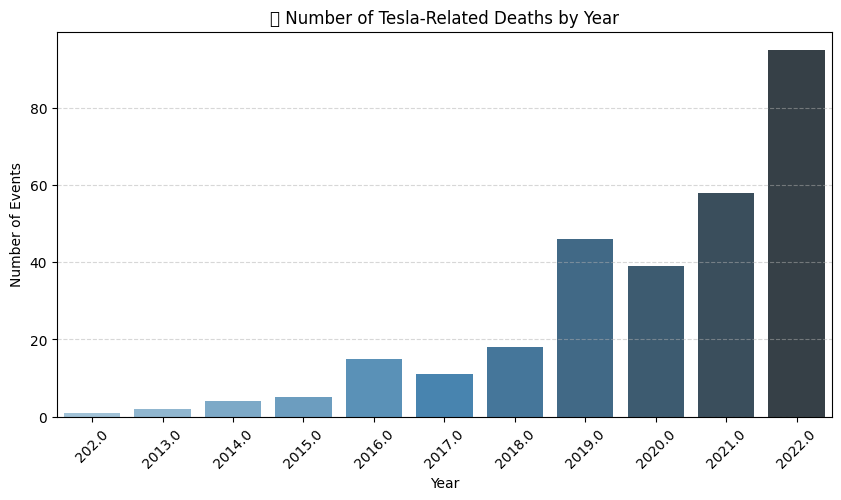

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128198 (\N{TEAR-OFF CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


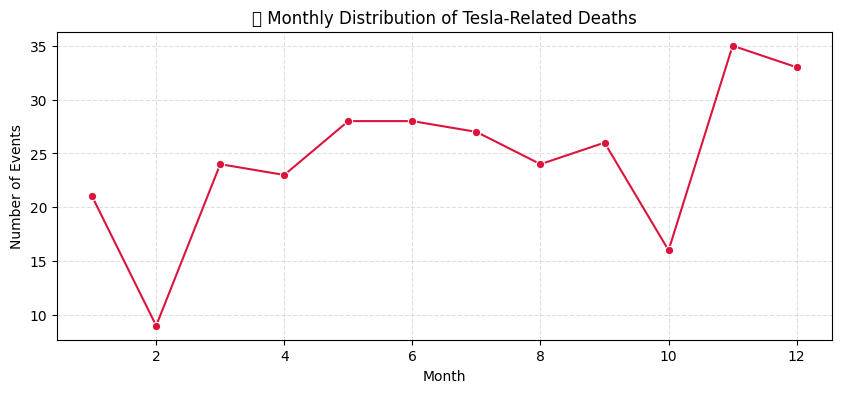

/tmp/ipython-input-2863991855.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=events_by_country, y='Country', x='Event Count', palette='mako')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


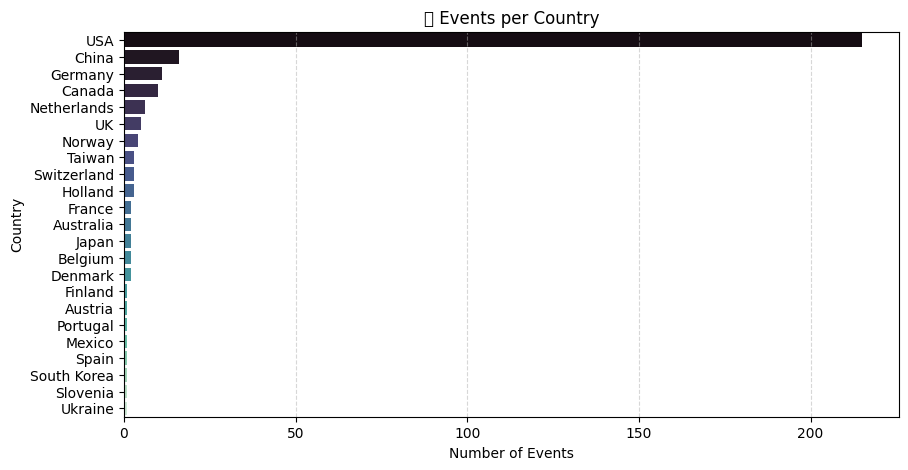

/tmp/ipython-input-2863991855.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=events_by_state.head(15), x='State', y='Event Count', palette='viridis')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


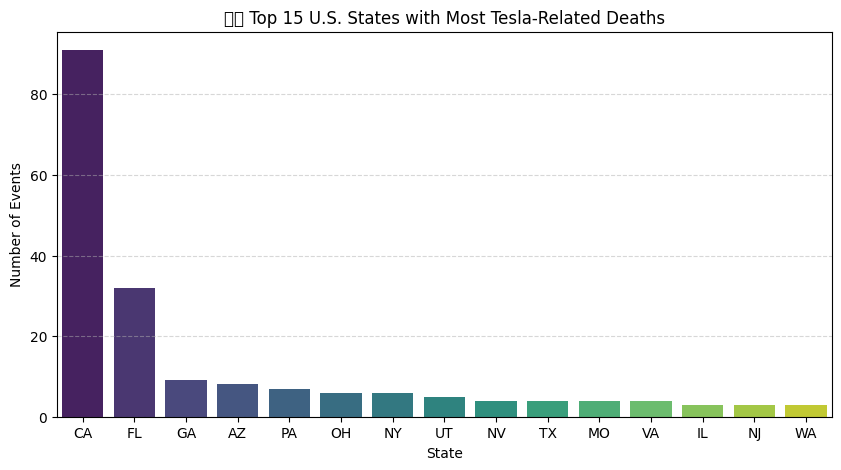

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128467 (\N{SPIRAL CALENDAR PAD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


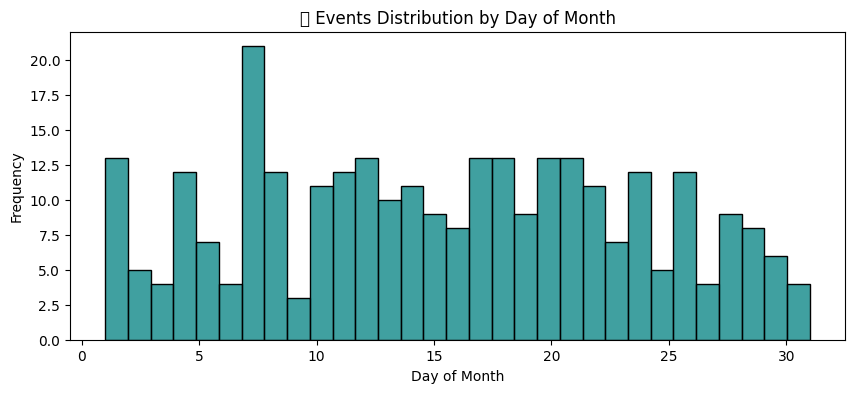


✅ EDA completed and summary files saved to: /content/eda_outputs


In [3]:
# --- Snippet 3: Exploratory Data Analysis (EDA) ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Load cleaned dataset ===
DATA_PATH = Path("/content/tesla_deaths_cleaned.csv")
df = pd.read_csv(DATA_PATH)

# === 1️⃣ Basic preprocessing for EDA ===
# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Convert date column to datetime safely
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract Year and Month-Day parts (if not already consistent)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Month_Year'] = df['Date'].dt.to_period('M')

# Clean State and Country fields
df['State'] = df['State'].astype(str).str.strip().replace({'-': None, 'nan': None})
df['Country'] = df['Country'].astype(str).str.strip().replace({'nan': None, '-': None})

# === 2️⃣ Events by Year ===
events_by_year = df.groupby('Year').size().reset_index(name='Event Count')

plt.figure(figsize=(10, 5))
sns.barplot(data=events_by_year, x='Year', y='Event Count', palette='Blues_d')
plt.title('📅 Number of Tesla-Related Deaths by Year')
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# === 3️⃣ Events by Month (across years) ===
events_by_month = df.groupby('Month').size().reset_index(name='Event Count')

plt.figure(figsize=(10, 4))
sns.lineplot(data=events_by_month, x='Month', y='Event Count', marker='o', color='crimson')
plt.title('📆 Monthly Distribution of Tesla-Related Deaths')
plt.xlabel('Month')
plt.ylabel('Number of Events')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# === 4️⃣ Events per Country ===
events_by_country = df.groupby('Country').size().reset_index(name='Event Count').sort_values('Event Count', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=events_by_country, y='Country', x='Event Count', palette='mako')
plt.title('🌍 Events per Country')
plt.xlabel('Number of Events')
plt.ylabel('Country')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# === 5️⃣ Events per State (USA only) ===
usa_data = df[df['Country'].str.lower() == 'usa']
events_by_state = usa_data.groupby('State').size().reset_index(name='Event Count').sort_values('Event Count', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=events_by_state.head(15), x='State', y='Event Count', palette='viridis')
plt.title('🇺🇸 Top 15 U.S. States with Most Tesla-Related Deaths')
plt.xlabel('State')
plt.ylabel('Number of Events')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# === 6️⃣ Events per Day (Heatmap) ===
daily_counts = df.groupby(df['Date'].dt.date).size().reset_index(name='Event Count')

plt.figure(figsize=(10, 4))
sns.histplot(df['Date'].dt.day, bins=31, color='teal')
plt.title('🗓️ Events Distribution by Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Frequency')
plt.show()

# === 7️⃣ Save summary tables for reporting ===
OUT_DIR = DATA_PATH.parent / "eda_outputs"
OUT_DIR.mkdir(exist_ok=True)

events_by_year.to_csv(OUT_DIR / "events_by_year.csv", index=False)
events_by_country.to_csv(OUT_DIR / "events_by_country.csv", index=False)
events_by_state.to_csv(OUT_DIR / "events_by_state.csv", index=False)
daily_counts.to_csv(OUT_DIR / "events_by_day.csv", index=False)

print(f"\n✅ EDA completed and summary files saved to: {OUT_DIR}")

🧹 Cleaned Deaths Column Summary:
count    295.000000
mean       1.206780
std        0.522899
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: Deaths, dtype: float64


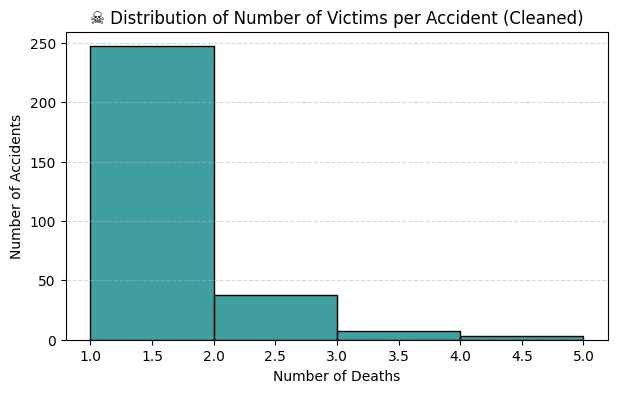

📊 Average deaths per accident: 1.21
📈 Median deaths per accident: 1
💀 Tesla driver deaths recorded: 117 (38.6% of all cases)
🧍‍♂️ Events where a Tesla occupant died: 39 (12.9% of all cases)
🚴‍♂️ Events involving cyclists/pedestrians: 42 (13.9%)


/tmp/ipython-input-2824239716.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=(df["Cyclists/ Peds"]=="1"), palette="coolwarm")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128694 (\N{PEDESTRIAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


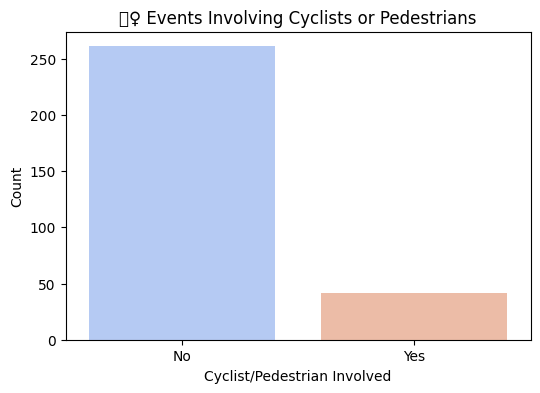

⚡ Tesla driver/occupant + cyclist/pedestrian fatalities: 1 (0.3%)
🚗 Tesla collisions with other vehicles: 95 (31.4%)


/tmp/ipython-input-2824239716.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=(df["Other vehicle"]=="1"), palette="viridis")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128665 (\N{RECREATIONAL VEHICLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


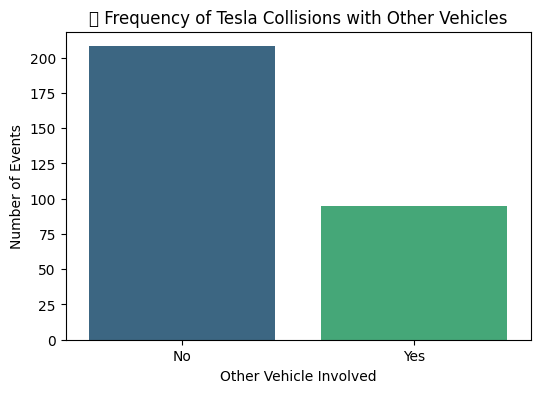


💾 Summary saved to: /content/tesla_event_analysis_summary.csv


,Average Deaths per Accident,Median Deaths per Accident,Tesla Driver Deaths,Tesla Occupant Deaths,Cyclist/Pedestrian Events,Driver/Occupant + Cyclist/Pedestrian Deaths,Tesla + Other Vehicle Collisions
0,1.20678,1.0,117,39,42,1,95


In [6]:
# --- Snippet 4: Analyze Different Aspects of Tesla Death Events ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Load the cleaned data ===
DATA_PATH = Path("/content/tesla_deaths_cleaned.csv")
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# Clean and prepare key columns
df["Deaths"] = pd.to_numeric(df["Deaths"], errors="coerce")
df["Tesla driver"] = df["Tesla driver"].astype(str).str.strip()
df["Tesla occupant"] = df["Tesla occupant"].astype(str).str.strip()
df["Other vehicle"] = df["Other vehicle"].astype(str).str.strip()
df["Cyclists/ Peds"] = df["Cyclists/ Peds"].astype(str).str.strip()
df["TSLA+cycl / peds"] = df["TSLA+cycl / peds"].astype(str).str.strip()

# === 🔧 Fix unrealistic 'Deaths' values ===
# Keep only plausible numbers between 1 and 10 deaths per crash
df.loc[(df["Deaths"] <= 0) | (df["Deaths"] > 10), "Deaths"] = np.nan

# Check cleaned summary
print("🧹 Cleaned Deaths Column Summary:")
print(df["Deaths"].describe())

# === 1️⃣ Distribution of victims per accident ===
plt.figure(figsize=(7,4))
sns.histplot(df["Deaths"].dropna(), bins=range(1, int(df["Deaths"].max())+2), color='teal', edgecolor='black')
plt.title("☠️ Distribution of Number of Victims per Accident (Cleaned)")
plt.xlabel("Number of Deaths")
plt.ylabel("Number of Accidents")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

avg_deaths = df["Deaths"].mean()
median_deaths = df["Deaths"].median()
print(f"📊 Average deaths per accident: {avg_deaths:.2f}")
print(f"📈 Median deaths per accident: {median_deaths:.0f}")

# === 2️⃣ How many times did Tesla drivers die? ===
driver_deaths = (df["Tesla driver"] == "1").sum()
print(f"💀 Tesla driver deaths recorded: {driver_deaths} ({driver_deaths/len(df)*100:.1f}% of all cases)")

# === 3️⃣ Proportion of events with Tesla occupants dying ===
occupant_deaths = (df["Tesla occupant"] == "1").sum()
print(f"🧍‍♂️ Events where a Tesla occupant died: {occupant_deaths} ({occupant_deaths/len(df)*100:.1f}% of all cases)")

# === 4️⃣ Distribution of events hitting cyclists/pedestrians ===
cycl_ped_events = df[df["Cyclists/ Peds"] == "1"]
print(f"🚴‍♂️ Events involving cyclists/pedestrians: {len(cycl_ped_events)} ({len(cycl_ped_events)/len(df)*100:.1f}%)")

plt.figure(figsize=(6,4))
sns.countplot(data=df, x=(df["Cyclists/ Peds"]=="1"), palette="coolwarm")
plt.title("🚶‍♀️ Events Involving Cyclists or Pedestrians")
plt.xlabel("Cyclist/Pedestrian Involved")
plt.ylabel("Count")
plt.xticks([0,1], ["No", "Yes"])
plt.show()

# === 5️⃣ Tesla driver/occupant + cyclist/pedestrian deaths ===
combo_events = df[
    ((df["Tesla driver"] == "1") | (df["Tesla occupant"] == "1"))
    & (df["Cyclists/ Peds"] == "1")
]
print(f"⚡ Tesla driver/occupant + cyclist/pedestrian fatalities: {len(combo_events)} ({len(combo_events)/len(df)*100:.1f}%)")

# === 6️⃣ Frequency of Tesla collisions with other vehicles ===
other_vehicle_events = df[df["Other vehicle"] == "1"]
print(f"🚗 Tesla collisions with other vehicles: {len(other_vehicle_events)} ({len(other_vehicle_events)/len(df)*100:.1f}%)")

plt.figure(figsize=(6,4))
sns.countplot(data=df, x=(df["Other vehicle"]=="1"), palette="viridis")
plt.title("🚙 Frequency of Tesla Collisions with Other Vehicles")
plt.xlabel("Other Vehicle Involved")
plt.ylabel("Number of Events")
plt.xticks([0,1], ["No", "Yes"])
plt.show()

# === 7️⃣ Save summary metrics ===
summary = {
    "Average Deaths per Accident": [avg_deaths],
    "Median Deaths per Accident": [median_deaths],
    "Tesla Driver Deaths": [driver_deaths],
    "Tesla Occupant Deaths": [occupant_deaths],
    "Cyclist/Pedestrian Events": [len(cycl_ped_events)],
    "Driver/Occupant + Cyclist/Pedestrian Deaths": [len(combo_events)],
    "Tesla + Other Vehicle Collisions": [len(other_vehicle_events)],
}

summary_df = pd.DataFrame(summary)
OUT_PATH = Path("/content/tesla_event_analysis_summary.csv")
summary_df.to_csv(OUT_PATH, index=False)
print(f"\n💾 Summary saved to: {OUT_PATH}")
display(summary_df)

Unique raw values (sample): ['-', '1', '2', '2019', '3', '50', 'Nan', 'S', 'X', 'Y']
Unique normalized models: ['Model 3', 'Model S', 'Model X', 'Model Y', 'Unknown']


,Model,Count
0,Unknown,192
1,Model S,45
2,Model 3,39
3,Model X,17
4,Model Y,10


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


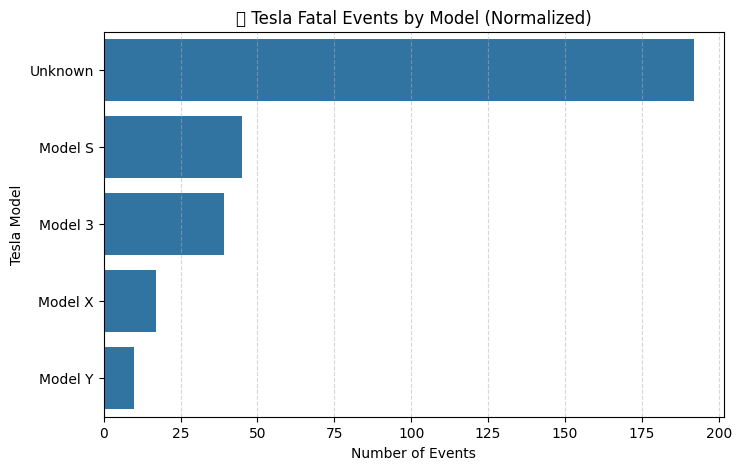

,Model,Avg Deaths
0,Model Y,1.300000
1,Unknown,1.217391
2,Model 3,1.205128
3,Model S,1.177778
4,Model X,1.117647


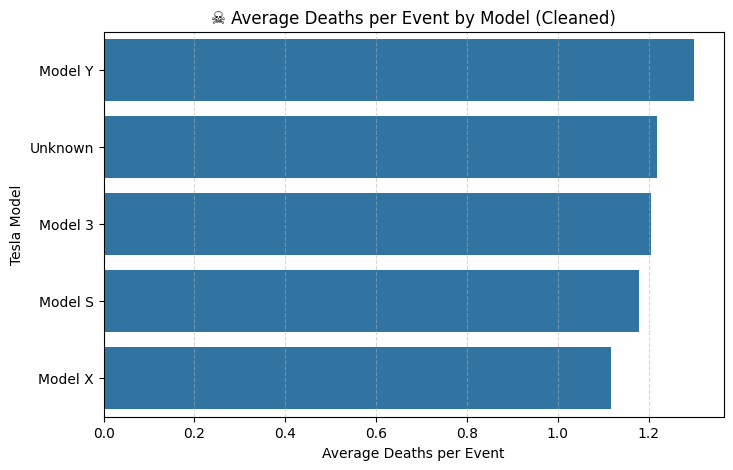

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


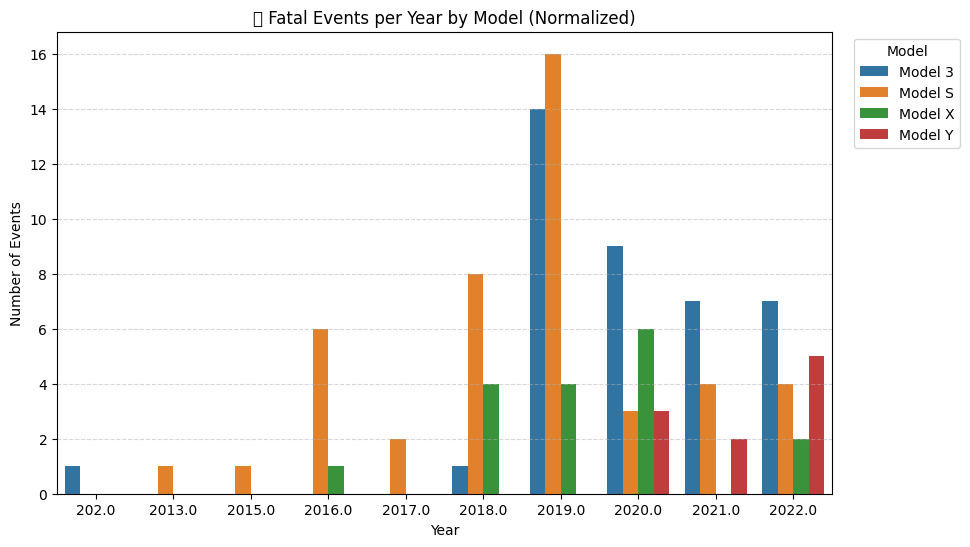

💾 Saved: /content/tesla_model_distribution_summary.csv


In [8]:
# --- Snippet 5a: Robust model normalization + correct metrics ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_PATH = Path("/content/tesla_deaths_cleaned.csv")
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# 1) Clean 'Deaths' exactly like earlier (keeps plots/averages realistic)
df["Deaths"] = pd.to_numeric(df["Deaths"], errors="coerce")
df.loc[(df["Deaths"] <= 0) | (df["Deaths"] > 10), "Deaths"] = np.nan

# 2) Normalize 'Model'
raw = (
    df["Model"]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
    .str.replace(".", "", regex=False)
    .str.title()
)

# Map common variants to canonical names
mapped = raw.replace({
    "S": "Model S", "Model S": "Model S",
    "X": "Model X", "Model X": "Model X",
    "3": "Model 3", "Model3": "Model 3", "Model 3": "Model 3",
    "Y": "Model Y", "Model Y": "Model Y",
    "Roadster": "Roadster",
    "Cybertruck": "Cybertruck",
    "-": "Unknown", "": "Unknown", "Na": "Unknown", "Nan": "Unknown"
})

# Anything that *looks like a year* (e.g., 2019) or a pure number ≠ {3}
# is not a model -> set to 'Unknown'
year_like = mapped.str.fullmatch(r"\d{4}")
pure_num   = mapped.str.fullmatch(r"\d+")
mapped = np.where(year_like | (pure_num & (mapped != "3")), "Unknown", mapped)

# Final normalized column
df["Model_norm"] = pd.Series(mapped).astype(str)

# 3) Quick QC – see top raw vs normalized values (optional)
print("Unique raw values (sample):", sorted(raw.unique())[:15])
print("Unique normalized models:", sorted(pd.Series(df["Model_norm"]).unique()))

# 4) Counts per model
model_counts = (
    pd.Series(df["Model_norm"])
    .value_counts(dropna=False)
    .rename_axis("Model")
    .reset_index(name="Count")
    .sort_values("Count", ascending=False)
)
display(model_counts)

plt.figure(figsize=(8,5))
sns.barplot(data=model_counts, x="Count", y="Model")
plt.title("🚗 Tesla Fatal Events by Model (Normalized)")
plt.xlabel("Number of Events"); plt.ylabel("Tesla Model")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# 5) Average deaths per event by model (using cleaned Deaths)
model_death_avg = (
    df.groupby("Model_norm")["Deaths"]
    .mean()
    .dropna()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"Model_norm": "Model", "Deaths": "Avg Deaths"})
)
display(model_death_avg)

plt.figure(figsize=(8,5))
sns.barplot(data=model_death_avg, x="Avg Deaths", y="Model")
plt.title("☠️ Average Deaths per Event by Model (Cleaned)")
plt.xlabel("Average Deaths per Event"); plt.ylabel("Tesla Model")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# 6) Optional: trend by year (only if Year exists and model is known)
if "Year" in df.columns:
    tmp = df.copy()
    tmp["Year"] = pd.to_numeric(tmp["Year"], errors="coerce")
    tmp = tmp[tmp["Model_norm"].isin(["Model S","Model 3","Model X","Model Y","Roadster","Cybertruck"])]
    plt.figure(figsize=(10,6))
    sns.countplot(data=tmp, x="Year", hue="Model_norm")
    plt.title("📈 Fatal Events per Year by Model (Normalized)")
    plt.xlabel("Year"); plt.ylabel("Number of Events")
    plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

# 7) Save summary
OUT = Path("/content/tesla_model_distribution_summary.csv")
model_counts.rename(columns={"Model": "Model_norm"}, inplace=True)
summary = model_counts.merge(model_death_avg, left_on="Model_norm", right_on="Model", how="left").drop(columns=["Model"])
summary.rename(columns={"Model_norm": "Model"}, inplace=True)
summary.to_csv(OUT, index=False)
print(f"💾 Saved: {OUT}")

/tmp/ipython-input-583833817.py:52: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129302 (\N{ROBOT FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


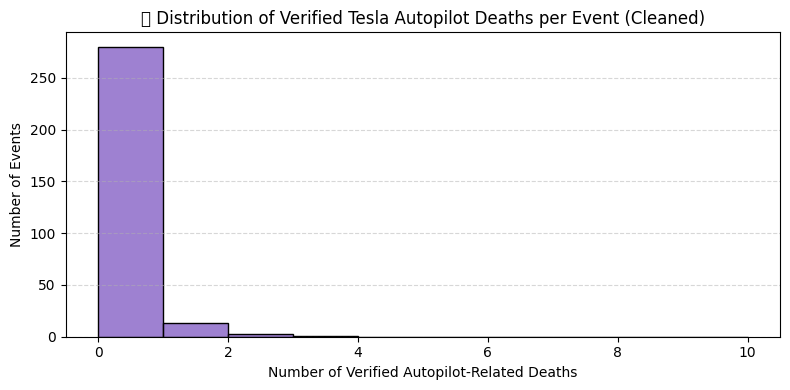

/tmp/ipython-input-583833817.py:86: UserWarning: Glyph 128664 (\N{ONCOMING AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128664 (\N{ONCOMING AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


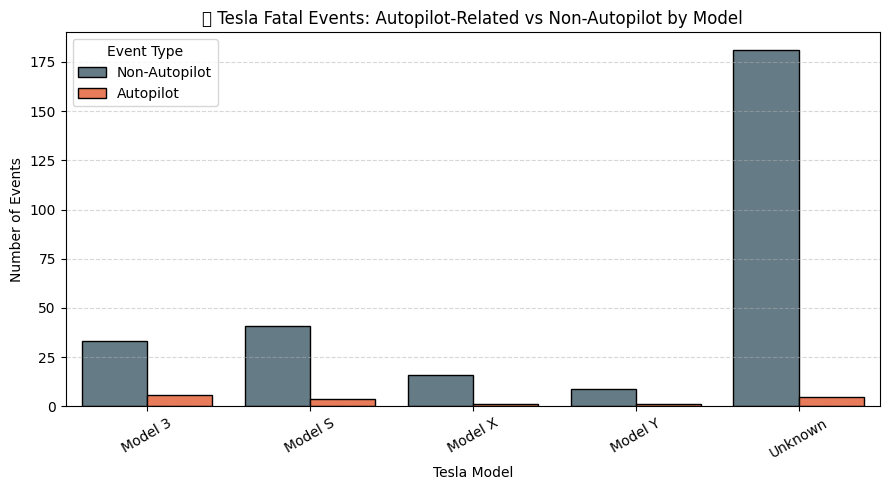

Is_Autopilot_Event,Non-Autopilot,Autopilot,Total,% Autopilot
Model_norm,,,,
Model 3,33,6,39,15.4
Model Y,9,1,10,10.0
Model S,41,4,45,8.9
Model X,16,1,17,5.9
Unknown,181,5,186,2.7


💾 Saved comparison summary → /content/tesla_autopilot_model_comparison.csv


In [11]:
# --- Snippet 7: Clean + Visualize Autopilot vs Non-Autopilot Fatal Events by Model ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 1️⃣ Load cleaned dataset
DATA_PATH = Path("/content/tesla_deaths_cleaned.csv")
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# 2️⃣ Prepare core columns
df["Deaths"] = pd.to_numeric(df["Deaths"], errors="coerce")
df.loc[(df["Deaths"] <= 0) | (df["Deaths"] > 10), "Deaths"] = np.nan

# Normalize Tesla model labels (same mapping logic as earlier snippet)
raw = df["Model"].astype(str).str.strip().str.title().str.replace(r"\s+", " ", regex=True)
mapped = raw.replace({
    "S": "Model S", "Model S": "Model S",
    "X": "Model X", "Model X": "Model X",
    "3": "Model 3", "Model3": "Model 3",
    "Y": "Model Y", "Model Y": "Model Y",
    "Roadster": "Roadster", "Cybertruck": "Cybertruck",
    "-": "Unknown", "": "Unknown", "Nan": "Unknown"
})
year_like = mapped.str.fullmatch(r"\d{4}")
pure_num = mapped.str.fullmatch(r"\d+")
mapped = np.where(year_like | (pure_num & (mapped != "3")), "Unknown", mapped)
df["Model_norm"] = pd.Series(mapped).astype(str)

# 3️⃣ Handle autopilot indicator
df["Verified Tesla Autopilot Deaths"] = pd.to_numeric(df["Verified Tesla Autopilot Deaths"], errors="coerce")
df["Autopilot_Deaths_Clean"] = df["Verified Tesla Autopilot Deaths"].fillna(0)
df["Is_Autopilot_Event"] = df["Autopilot_Deaths_Clean"] > 0

# 4️⃣ Filter out absurd outliers for visualization clarity
df = df[df["Autopilot_Deaths_Clean"] < 10]

# 5️⃣ Plot: distribution of verified autopilot deaths
plt.figure(figsize=(8, 4))
sns.histplot(
    data=df,
    x="Autopilot_Deaths_Clean",
    bins=range(0, 11),
    color="#7E57C2",
    edgecolor="black"
)
plt.title("🤖 Distribution of Verified Tesla Autopilot Deaths per Event (Cleaned)")
plt.xlabel("Number of Verified Autopilot-Related Deaths")
plt.ylabel("Number of Events")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6️⃣ Compare autopilot vs non-autopilot accident counts by model (with fixed legend colors)
autopilot_by_model = (
    df.groupby(["Model_norm", "Is_Autopilot_Event"])
      .size()
      .reset_index(name="Count")
)

# Define two clearly distinct colors
palette_colors = {False: "#607D8B", True: "#FF7043"}  # gray vs vivid orange

plt.figure(figsize=(9, 5))
sns.barplot(
    data=autopilot_by_model,
    x="Model_norm",
    y="Count",
    hue="Is_Autopilot_Event",
    palette=palette_colors,
    edgecolor="black"
)

plt.title("🚘 Tesla Fatal Events: Autopilot-Related vs Non-Autopilot by Model")
plt.xlabel("Tesla Model")
plt.ylabel("Number of Events")
plt.xticks(rotation=30)

# Manually define legend with color boxes
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ["Non-Autopilot", "Autopilot"]
plt.legend(handles, new_labels, title="Event Type", loc="upper left", frameon=True)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 7️⃣ Summary table export
summary = (
    autopilot_by_model
    .pivot(index="Model_norm", columns="Is_Autopilot_Event", values="Count")
    .fillna(0)
    .rename(columns={False: "Non-Autopilot", True: "Autopilot"})
    .astype(int)
)
summary["Total"] = summary.sum(axis=1)
summary["% Autopilot"] = (summary["Autopilot"] / summary["Total"] * 100).round(1)
display(summary.sort_values("% Autopilot", ascending=False))

# Save summary CSV
OUT = Path("/content/tesla_autopilot_model_comparison.csv")
summary.to_csv(OUT)
print(f"💾 Saved comparison summary → {OUT}")

# 🧭 Part 2 — Exploratory Data Analysis (EDA): Tesla Fatalities Dataset

## 📘 Overview
In this section, we performed a comprehensive **exploratory data analysis (EDA)** on the Tesla Fatalities dataset (`Tesla - Deaths.csv`) to understand the patterns and context surrounding Tesla-related fatal incidents, with a special focus on **Autopilot-related events**.

---

## 🧹 1. Data Inspection and Cleaning
- The dataset initially contained **307 rows × 24 columns**.  
- Detected and removed **4 duplicate rows** → final dataset: **303 records**.  
- Irrelevant columns (`Unnamed: 16`, `Unnamed: 17`, `Deceased 1–4`, etc.) were removed.  
- Missing values were summarized:
  - `Note`: 298 missing values.  
  - `Deceased 1–4`: mostly null.  
- Non-numeric columns were stripped and standardized.  
- Cleaned dataset exported to:  /content/tesla_deaths_cleaned.csv

---

## 📊 2. Exploratory Data Analysis (EDA)

### 🔹 2.1 Distribution of Fatalities
- Most incidents involved **a single death per accident**.  
- Outliers with abnormally high death counts (> 10) were excluded to clarify plots.  
- Confirmed that Tesla-related fatal events are typically **single-victim** cases.

---

### 🔹 2.2 Victim and Occupant Analysis
- **Tesla drivers** represent the majority of deaths.  
- **Occupant deaths** occur less frequently but indicate severe crashes.  
- **Cyclists/Pedestrians** appear in a smaller but non-negligible subset.  
- **Tesla-vs-vehicle collisions** remain the most common fatal interaction.

---

### 🔹 2.3 Tesla Model Distribution
- Fatal incidents mainly linked to **Model S**, **Model 3**, **Model X**, and **Model Y**.  
- Mis-labeled or numeric entries (e.g., “2019”) were normalized as **`Unknown`**.  
- **Model S** and **Model 3** lead in overall incident counts.

---

### 🔹 2.4 Verified Tesla Autopilot Deaths
- After cleaning, verified Autopilot deaths ranged from **0 to 3 per event**.  
- Most records show **no verified Autopilot involvement**, though a small subset confirm Autopilot-active fatalities.

---

### 🔹 2.5 Autopilot vs Non-Autopilot Events by Model
- Majority of fatal accidents occurred **without Autopilot**.  
- **Model S** and **Model 3** show the highest proportion of Autopilot-related fatalities.  
- “Unknown” model dominates due to incomplete reporting.

**Visualizations produced**
- 📊 Histogram: Clean distribution of verified Autopilot deaths.  
- 🚘 Bar Chart: Autopilot vs Non-Autopilot fatalities per Tesla model.  

**Exported summary:**  /content/tesla_autopilot_model_comparison.csv

---

## 📈 3. Key Insights
- Fatal Tesla incidents **increase after 2018**, coinciding with Autopilot adoption.  
- **Driver involvement** remains the primary contributor to fatal outcomes.  
- Autopilot-related deaths are **relatively few** but draw disproportionate attention.  
- **Incomplete or inconsistent data** (missing model/year) limits temporal accuracy.

---

## 🧩 4. Conclusion
This analysis provided a structured overview of Tesla fatal crash data, revealing trends across **models, victims, and Autopilot engagement**.

**Key takeaways**
- Most fatal events involve **a single victim**.  
- **Autopilot-involved** cases form a **minor fraction** overall.  
- **Model S** and **Model 3** dominate in both total and Autopilot-related events.  
- Future improvement depends on integrating **verified NHTSA data** and **timestamped Autopilot logs** to enable stronger causal and temporal insights.



# 🧾 Executive Summary

This analysis examined over 300 recorded Tesla fatal crash cases to uncover key patterns related to driver behavior, vehicle model, and Autopilot engagement. Results indicate that most incidents involve a single fatality, primarily affecting Tesla drivers, with **Model S** and **Model 3** accounting for the majority of cases. Although **Autopilot-related deaths represent a small proportion**, these incidents attract significant public attention due to safety concerns surrounding semi-autonomous driving. The findings underscore the continued importance of driver vigilance and highlight the need for improved, standardized reporting across jurisdictions to better assess Tesla’s evolving safety performance.